In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [110]:
fear_df=pd.read_csv('../data/raw/fear_greed_index.csv')
print("=== FEAR & GREED DATASET ===")
print(f"Shape: {fear_df.shape}")
fear_df.head()

=== FEAR & GREED DATASET ===
Shape: (2644, 4)


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [111]:
# Load Historical Trading dataset
trading_df = pd.read_csv('../data/raw/historical_data.csv')
print(f"\n=== TRADING DATASET ===")
print(f"Shape: {trading_df.shape}")
trading_df.tail()


=== TRADING DATASET ===
Shape: (211224, 16)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
211219,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,FARTCOIN,1.101,382.2,420.80,SELL,25-04-2025 15:35,7546.6,Close Long,-20.2566,0xcd339c08dc7b615a993c0422374d8e02027400092bc2...,88803313862,False,0.042080,1.990000e+14,1.750000e+12
211220,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,FARTCOIN,1.101,2124.1,2338.63,SELL,25-04-2025 15:35,7164.4,Close Long,-112.5773,0x29e8ede2a3a37aa0eac00422374d8e02029b00ac9f3c...,88803313862,False,0.233863,9.260000e+14,1.750000e+12
211221,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,FARTCOIN,1.101,423.4,466.16,SELL,25-04-2025 15:35,5040.3,Close Long,-22.4402,0x0780085b0c0a943eea800422374d920204c100edf579...,88803313862,False,0.046616,6.930000e+14,1.750000e+12
211222,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,FARTCOIN,1.101,3599.8,3963.38,SELL,25-04-2025 15:35,4616.9,Close Long,-190.7894,0x349c29934913b25c89e20422374d920204cd008b8a0e...,88803313862,False,0.396337,4.180000e+14,1.750000e+12
211223,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,FARTCOIN,1.101,1017.1,1119.83,SELL,25-04-2025 15:35,1017.1,Close Long,-53.9063,0xac77fab973c455d77a670422374d9602039800f1f78c...,88803313862,False,0.111982,3.270000e+14,1.750000e+12


In [112]:
#Step 1:  Preprocessing dates and aggregating trading data daily per trader

# Converting 'date' column in Fear & Greed dataset to datetime
fear_df['date'] = pd.to_datetime(fear_df['date'])

# Converting 'Timestamp IST' to datetime in trading dataset and extract date
trading_df['Timestamp IST'] = pd.to_datetime(trading_df['Timestamp IST'], format='%d-%m-%Y %H:%M')
trading_df['date'] = trading_df['Timestamp IST'].dt.date

# Converting trading date to datetime for proper merging
trading_df['date'] = pd.to_datetime(trading_df['date'])

# Aggregating daily trader performance
daily_trader_perf = trading_df.groupby(['date', 'Account']).agg({
    'Closed PnL': 'sum',
    'Size USD': 'sum',
    'Fee': 'sum',
    'Transaction Hash': 'count'
}).rename(columns={
    'Closed PnL': 'Daily_PnL',
    'Size USD': 'Daily_Volume',
    'Fee': 'Daily_Fees',
    'Transaction Hash': 'Daily_Trades'
}).reset_index()

print("=== DAILY TRADER PERFORMANCE AGGREGATED ===")
print(f"Shape: {daily_trader_perf.shape}")
print(f"Date range: {daily_trader_perf['date'].min()} to {daily_trader_perf['date'].max()}")
print(f"Unique traders: {daily_trader_perf['Account'].nunique()}")
print("\nFirst 5 rows:")
daily_trader_perf.head()


=== DAILY TRADER PERFORMANCE AGGREGATED ===
Shape: (2341, 6)
Date range: 2023-05-01 00:00:00 to 2025-05-01 00:00:00
Unique traders: 32

First 5 rows:


,date,Account,Daily_PnL,Daily_Volume,Daily_Fees,Daily_Trades
0,2023-05-01,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,0.000000,477.00,0.000000,3
1,2023-12-05,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,0.000000,50005.83,12.501455,9
2,2023-12-14,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,-205.434737,113203.35,28.300831,11
3,2023-12-15,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,-24.632034,10609.95,2.652489,2
4,2023-12-16,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,0.000000,15348.77,3.837189,3


In [113]:
print(f"\n=== AGGREGATION SUMMARY ===")
print(f"Original transactions: 2,11,224 → Daily records: {len(daily_trader_perf)}")
print(f"Average daily PnL: ${daily_trader_perf['Daily_PnL'].mean():.2f}")
print(f"Average daily volume: ${daily_trader_perf['Daily_Volume'].mean():,.2f}")


=== AGGREGATION SUMMARY ===
Original transactions: 2,11,224 → Daily records: 2341
Average daily PnL: $4398.53
Average daily volume: $508,837.01


In [114]:
# Step 2: Aggregating daily trader-coin performance (incorporating coin analysis)

# Aggregating at daily trader-coin level this time and not on just trader level
daily_trader_coin_perf = trading_df.groupby(['date', 'Account', 'Coin']).agg({
    'Closed PnL': 'sum',
    'Size USD': 'sum',
    'Fee': 'sum',
    'Transaction Hash': 'count'
}).rename(columns={
    'Closed PnL': 'Daily_PnL',
    'Size USD': 'Daily_Volume',
    'Fee': 'Daily_Fees',
    'Transaction Hash': 'Daily_Trades'
}).reset_index()

print("=== COIN-LEVEL DAILY AGGREGATION ===")
print(f"Shape: {daily_trader_coin_perf.shape}")
print(f"Date range: {daily_trader_coin_perf['date'].min()} to {daily_trader_coin_perf['date'].max()}")
print(f"Unique traders: {daily_trader_coin_perf['Account'].nunique()}")
print(f"Unique coins: {daily_trader_coin_perf['Coin'].nunique()}")
print("\nTop 10 most traded coins:")
print(daily_trader_coin_perf['Coin'].value_counts().head(10))

# Merge with Fear & Greed sentiment data
combined_coin_df = daily_trader_coin_perf.merge(
    fear_df[['date', 'value', 'classification']], 
    on='date', 
    how='inner'
)


=== COIN-LEVEL DAILY AGGREGATION ===
Shape: (7121, 7)
Date range: 2023-05-01 00:00:00 to 2025-05-01 00:00:00
Unique traders: 32
Unique coins: 246

Top 10 most traded coins:
Coin
BTC          667
@107         575
HYPE         503
ETH          476
SOL          322
FARTCOIN     204
SUI          201
PURR/USDC    183
XRP          146
WLD          119
Name: count, dtype: int64


In [115]:
print(f"\n=== MERGED COIN-SENTIMENT DATASET ===")
print(f"Shape: {combined_coin_df.shape}")
print(f"Records per sentiment class:")
print(combined_coin_df['classification'].value_counts())


=== MERGED COIN-SENTIMENT DATASET ===
Shape: (7120, 9)
Records per sentiment class:
classification
Greed            2135
Extreme Greed    1972
Fear             1474
Neutral          1078
Extreme Fear      461
Name: count, dtype: int64


In [116]:
print(f"\nFirst 5 rows:")
combined_coin_df.head()


First 5 rows:


,date,Account,Coin,Daily_PnL,Daily_Volume,Daily_Fees,Daily_Trades,value,classification
0,2023-05-01,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,ETH,0.000000,477.00,0.000000,3,63,Greed
1,2023-12-05,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,BTC,0.000000,24998.62,6.249655,2,75,Extreme Greed
2,2023-12-05,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,ETH,0.000000,25007.21,6.251800,7,75,Extreme Greed
3,2023-12-14,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,AAVE,76.369902,51839.62,12.959901,6,72,Greed
4,2023-12-14,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,BTC,-527.233130,25525.84,6.381460,2,72,Greed


In [117]:
combined_coin_df['Perfomance']=np.where(combined_coin_df['Daily_PnL']<0,"Loss",np.where(combined_coin_df['Daily_PnL']>0,"Profit","Neutral"))
combined_coin_df.head()

,date,Account,Coin,Daily_PnL,Daily_Volume,Daily_Fees,Daily_Trades,value,classification,Perfomance
0,2023-05-01,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,ETH,0.000000,477.00,0.000000,3,63,Greed,Neutral
1,2023-12-05,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,BTC,0.000000,24998.62,6.249655,2,75,Extreme Greed,Neutral
2,2023-12-05,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,ETH,0.000000,25007.21,6.251800,7,75,Extreme Greed,Neutral
3,2023-12-14,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,AAVE,76.369902,51839.62,12.959901,6,72,Greed,Profit
4,2023-12-14,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,BTC,-527.233130,25525.84,6.381460,2,72,Greed,Loss


In [118]:
# Step 3: Creating trader clustering from daily performance data considering the coins AND performance outcomes!
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# First, fix the typo in the Performance column
combined_coin_df['Performance'] = combined_coin_df['Perfomance']

# Calculate performance distribution for each trader
trader_performance_dist = combined_coin_df.groupby('Account')['Performance'].value_counts(normalize=True).unstack(fill_value=0)
trader_performance_dist.columns = [f'{col}_Rate' for col in trader_performance_dist.columns]

# Aggregate total trader performance metrics from coin-level data
trader_perf_summary = daily_trader_coin_perf.groupby('Account').agg({
    'Daily_PnL': 'sum',
    'Daily_Volume': 'sum', 
    'Daily_Trades': 'sum',
    'Daily_Fees': 'sum'
}).rename(columns={
    'Daily_PnL': 'Total_PnL',
    'Daily_Volume': 'Total_Volume',
    'Daily_Trades': 'Total_Trades',
    'Daily_Fees': 'Total_Fees'
})

# Calculate additional performance metrics
trader_perf_summary['Avg_PnL_per_Trade'] = trader_perf_summary['Total_PnL'] / trader_perf_summary['Total_Trades']
trader_perf_summary['Net_PnL'] = trader_perf_summary['Total_PnL'] - trader_perf_summary['Total_Fees']
trader_perf_summary['PnL_per_Dollar_Volume'] = trader_perf_summary['Total_PnL'] / trader_perf_summary['Total_Volume']

# Merge with performance distribution rates
trader_perf_summary = trader_perf_summary.merge(trader_performance_dist, left_index=True, right_index=True, how='left')

print("=== ENHANCED TRADER PERFORMANCE SUMMARY FOR CLUSTERING ===")
print(f"Shape: {trader_perf_summary.shape}")
print("New columns added:", [col for col in trader_perf_summary.columns if '_Rate' in col])
trader_perf_summary.head()


=== ENHANCED TRADER PERFORMANCE SUMMARY FOR CLUSTERING ===
Shape: (32, 10)
New columns added: ['Loss_Rate', 'Neutral_Rate', 'Profit_Rate']


,Total_PnL,Total_Volume,Total_Trades,Total_Fees,Avg_PnL_per_Trade,Net_PnL,PnL_per_Dollar_Volume,Loss_Rate,Neutral_Rate,Profit_Rate
Account,,,,,,,,,,
0x083384f897ee0f19899168e3b1bec365f52a9012,1.600230e+06,61697263.97,3818,7405.312304,419.127768,1.592825e+06,0.025937,0.200000,0.200000,0.600000
0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,4.788532e+04,12035487.66,7280,2729.837889,6.577654,4.515548e+04,0.003979,0.186667,0.200000,0.613333
0x271b280974205ca63b716753467d5a371de622ab,-7.043619e+04,33873440.42,3809,9280.982850,-18.492043,-7.971717e+04,-0.002079,0.250000,0.285714,0.464286
0x28736f43f1e871e6aa8b1148d38d4994275d72c4,1.324648e+05,6757022.10,13311,2218.367366,9.951530,1.302464e+05,0.019604,0.099387,0.286590,0.614023
0x2c229d22b100a7beb69122eed721cee9b24011dd,1.686580e+05,10166880.20,3239,3108.196722,52.071011,1.655498e+05,0.016589,0.223404,0.000000,0.776596


In [119]:
# Handle infinite and missing values even though there are no infinite and empty values just an extra caution
trader_perf_summary = trader_perf_summary.replace([np.inf, -np.inf], np.nan).dropna()

# Prepare features for clustering - NOW INCLUDING PERFORMANCE RATES
clustering_features = trader_perf_summary[['Total_Trades', 'Total_PnL', 'Total_Volume', 'Avg_PnL_per_Trade', 'PnL_per_Dollar_Volume', 'Loss_Rate', 'Profit_Rate', 'Neutral_Rate']]

print("=== ENHANCED CLUSTERING FEATURES ===")
print(f"Features for clustering: {list(clustering_features.columns)}")
print(f"Shape: {clustering_features.shape}")

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(clustering_features)

# Apply K-means clustering with k=4
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(features_scaled)

# Add cluster labels
trader_perf_summary['Cluster'] = clusters

print(f"\n=== ENHANCED CLUSTERING RESULTS ===")
print("Cluster distribution:")
print(trader_perf_summary['Cluster'].value_counts().sort_index())

print(f"\nFirst 5 rows with new clustering:")
print(trader_perf_summary.head())


=== ENHANCED CLUSTERING FEATURES ===
Features for clustering: ['Total_Trades', 'Total_PnL', 'Total_Volume', 'Avg_PnL_per_Trade', 'PnL_per_Dollar_Volume', 'Loss_Rate', 'Profit_Rate', 'Neutral_Rate']
Shape: (32, 8)

=== ENHANCED CLUSTERING RESULTS ===
Cluster distribution:
Cluster
0     3
1    13
2     4
3    12
Name: count, dtype: int64

First 5 rows with new clustering:
                                               Total_PnL  Total_Volume  \
Account                                                                  
0x083384f897ee0f19899168e3b1bec365f52a9012  1.600230e+06   61697263.97   
0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd  4.788532e+04   12035487.66   
0x271b280974205ca63b716753467d5a371de622ab -7.043619e+04   33873440.42   
0x28736f43f1e871e6aa8b1148d38d4994275d72c4  1.324648e+05    6757022.10   
0x2c229d22b100a7beb69122eed721cee9b24011dd  1.686580e+05   10166880.20   

                                            Total_Trades   Total_Fees  \
Account                            

In [120]:
# Analyze cluster characteristics - NOW INCLUDING PERFORMANCE RATES
cluster_summary = trader_perf_summary.groupby('Cluster').agg({
    'Total_Trades': ['mean', 'median'],
    'Total_PnL': ['mean', 'median'], 
    'Total_Volume': ['mean', 'median'],
    'Avg_PnL_per_Trade': ['mean', 'median'],
    'Loss_Rate': ['mean', 'median'],
    'Profit_Rate': ['mean', 'median'],
    'Neutral_Rate': ['mean', 'median']
}).round(4)

print(f"\n=== ENHANCED CLUSTER CHARACTERISTICS WITH PERFORMANCE RATES ===")
cluster_summary


=== ENHANCED CLUSTER CHARACTERISTICS WITH PERFORMANCE RATES ===


Total_Trades              Total_PnL                Total_Volume  \
                mean   median          mean        median          mean   
Cluster                                                                   
0         10262.3333  12236.0  1.528012e+06  1.600230e+06  1.797058e+08   
1         11385.8462   8519.0  2.107170e+05  1.033437e+05  3.070794e+07   
2          1006.2500   1106.0  2.819475e+05  3.012585e+05  2.183210e+06   
3          2366.3333   1750.5  1.538177e+05  7.034605e+04  2.034450e+07   

                      Avg_PnL_per_Trade           Loss_Rate          \
               median              mean    median      mean  median   
Cluster                                                               
0        6.169726e+07          211.0980  145.4817    0.1221  0.1277   
1        1.719338e+07           14.9003    9.5577    0.1330  0.1313   
2        2.476818e+06          312.7458  309.2809    0.0296  0.0093   
3        1.056806e+07           87.3317   62.4862    0.0868  0.0707   

        Profit_Rate         Neutral_Rate          
               mean  median         mean  median  
Cluster                                           
0            0.5222  0.5962       0.3557  0.3654  
1            0.6592  0.6320       0.2078  0.2333  
2            0.3302  0.3175       0.6402  0.6325  
3            0.4132  0.4158       0.5000  0.5492

In [121]:
# Additional analysis - Performance pattern by cluster
print(f"\n=== CLUSTER PERFORMANCE PATTERNS ===")
for cluster in sorted(trader_perf_summary['Cluster'].unique()):
    cluster_data = trader_perf_summary[trader_perf_summary['Cluster'] == cluster]
    print(f"\nCluster {cluster} ({len(cluster_data)} traders):")
    print(f"  Average Loss Rate: {cluster_data['Loss_Rate'].mean():.3f}")
    print(f"  Average Profit Rate: {cluster_data['Profit_Rate'].mean():.3f}")  
    print(f"  Average Neutral Rate: {cluster_data['Neutral_Rate'].mean():.3f}")
    print(f"  Average Total PnL: ${cluster_data['Total_PnL'].mean():,.0f}")
    print(f"  Average PnL per Trade: ${cluster_data['Avg_PnL_per_Trade'].mean():.2f}")



=== CLUSTER PERFORMANCE PATTERNS ===

Cluster 0 (3 traders):
  Average Loss Rate: 0.122
  Average Profit Rate: 0.522
  Average Neutral Rate: 0.356
  Average Total PnL: $1,528,012
  Average PnL per Trade: $211.10

Cluster 1 (13 traders):
  Average Loss Rate: 0.133
  Average Profit Rate: 0.659
  Average Neutral Rate: 0.208
  Average Total PnL: $210,717
  Average PnL per Trade: $14.90

Cluster 2 (4 traders):
  Average Loss Rate: 0.030
  Average Profit Rate: 0.330
  Average Neutral Rate: 0.640
  Average Total PnL: $281,948
  Average PnL per Trade: $312.75

Cluster 3 (12 traders):
  Average Loss Rate: 0.087
  Average Profit Rate: 0.413
  Average Neutral Rate: 0.500
  Average Total PnL: $153,818
  Average PnL per Trade: $87.33


In [122]:
# Step 5: Merge cluster information with coin-sentiment dataset
combined_final_df = combined_coin_df.merge(
    trader_perf_summary[['Cluster']], 
    left_on='Account', 
    right_index=True, 
    how='left'
)

print("=== FINAL COMBINED DATASET ===")
print(f"Shape: {combined_final_df.shape}")
print(f"Cluster distribution in daily records:")
print(combined_final_df['Cluster'].value_counts())

# Core Analysis: Performance by Sentiment and Cluster
performance_by_sentiment_cluster = combined_final_df.groupby(['classification', 'Cluster']).agg({
    'Daily_PnL': ['mean', 'median', 'count'],
    'Daily_Volume': 'mean',
    'Daily_Trades': 'mean'
}).round(2)


=== FINAL COMBINED DATASET ===
Shape: (7120, 12)
Cluster distribution in daily records:
Cluster
1    5178
3    1035
0     638
2     269
Name: count, dtype: int64


In [123]:
print(f"\n=== PERFORMANCE BY SENTIMENT & CLUSTER ===")
performance_by_sentiment_cluster


=== PERFORMANCE BY SENTIMENT & CLUSTER ===


Daily_PnL              Daily_Volume Daily_Trades
                            mean median count         mean         mean
classification Cluster                                                 
Extreme Fear   0         2633.01   0.00    24    253532.77        49.38
               1          647.12   0.00   307    252983.87        54.72
               2         6574.97   0.00    32     41046.54        15.75
               3         2723.00   0.00    98    300203.44        29.72
Extreme Greed  0        10757.80   0.00    99    174795.12        28.39
               1          684.74  11.06  1625     31109.84        19.13
               2         6735.67   0.00    30     38892.08        17.37
               3         1538.43   0.12   218    254312.84        25.53
Fear           0        11922.01   0.00   132   1970769.06        81.55
               1          974.15  11.51   939    172867.20        45.75
               2         2375.64   0.00   106     20333.25        10.61
               3         2077.12   0.00   297    197662.10        23.54
Greed          0         3716.89   0.00   262    637294.97        36.76
               1          251.07   4.54  1536     36297.44        20.27
               2         4042.29   0.00    72     41682.87        21.79
               3         1885.36   0.00   265    237196.90        30.08
Neutral        0         7506.53   0.00   121    732356.08        52.85
               1          165.48   6.92   771     68623.21        33.77
               2         4482.29   0.00    29     34738.85        10.34
               3          809.28   0.00   157    240197.80        31.55

In [124]:
# Create pivot table for clear sentiment-cluster matrix using NEW cluster assignments
sentiment_cluster_pivot = combined_final_df.pivot_table(
    values='Daily_PnL',
    index='classification',
    columns='Cluster',
    aggfunc='mean'
).round(2)

print(f"\n=== AVERAGE DAILY PnL BY SENTIMENT & ENHANCED CLUSTERS ===")
print(sentiment_cluster_pivot)

# Additional analysis: Performance pattern distribution by sentiment
performance_sentiment_analysis = combined_final_df.groupby(['classification', 'Cluster', 'Performance']).size().unstack(fill_value=0)
print(f"\n=== PERFORMANCE DISTRIBUTION BY SENTIMENT & CLUSTER ===")
print(performance_sentiment_analysis)



=== AVERAGE DAILY PnL BY SENTIMENT & ENHANCED CLUSTERS ===
Cluster                0       1        2        3
classification                                    
Extreme Fear     2633.01  647.12  6574.97  2723.00
Extreme Greed   10757.80  684.74  6735.67  1538.43
Fear            11922.01  974.15  2375.64  2077.12
Greed            3716.89  251.07  4042.29  1885.36
Neutral          7506.53  165.48  4482.29   809.28

=== PERFORMANCE DISTRIBUTION BY SENTIMENT & CLUSTER ===
Performance             Loss  Neutral  Profit
classification Cluster                       
Extreme Fear   0           3       12       9
               1          52      117     138
               2           3       15      14
               3          14       41      43
Extreme Greed  0          14       38      47
               1         166      334    1125
               2           0       20      10
               3          15       94     109
Fear           0           2       79      51
               1    

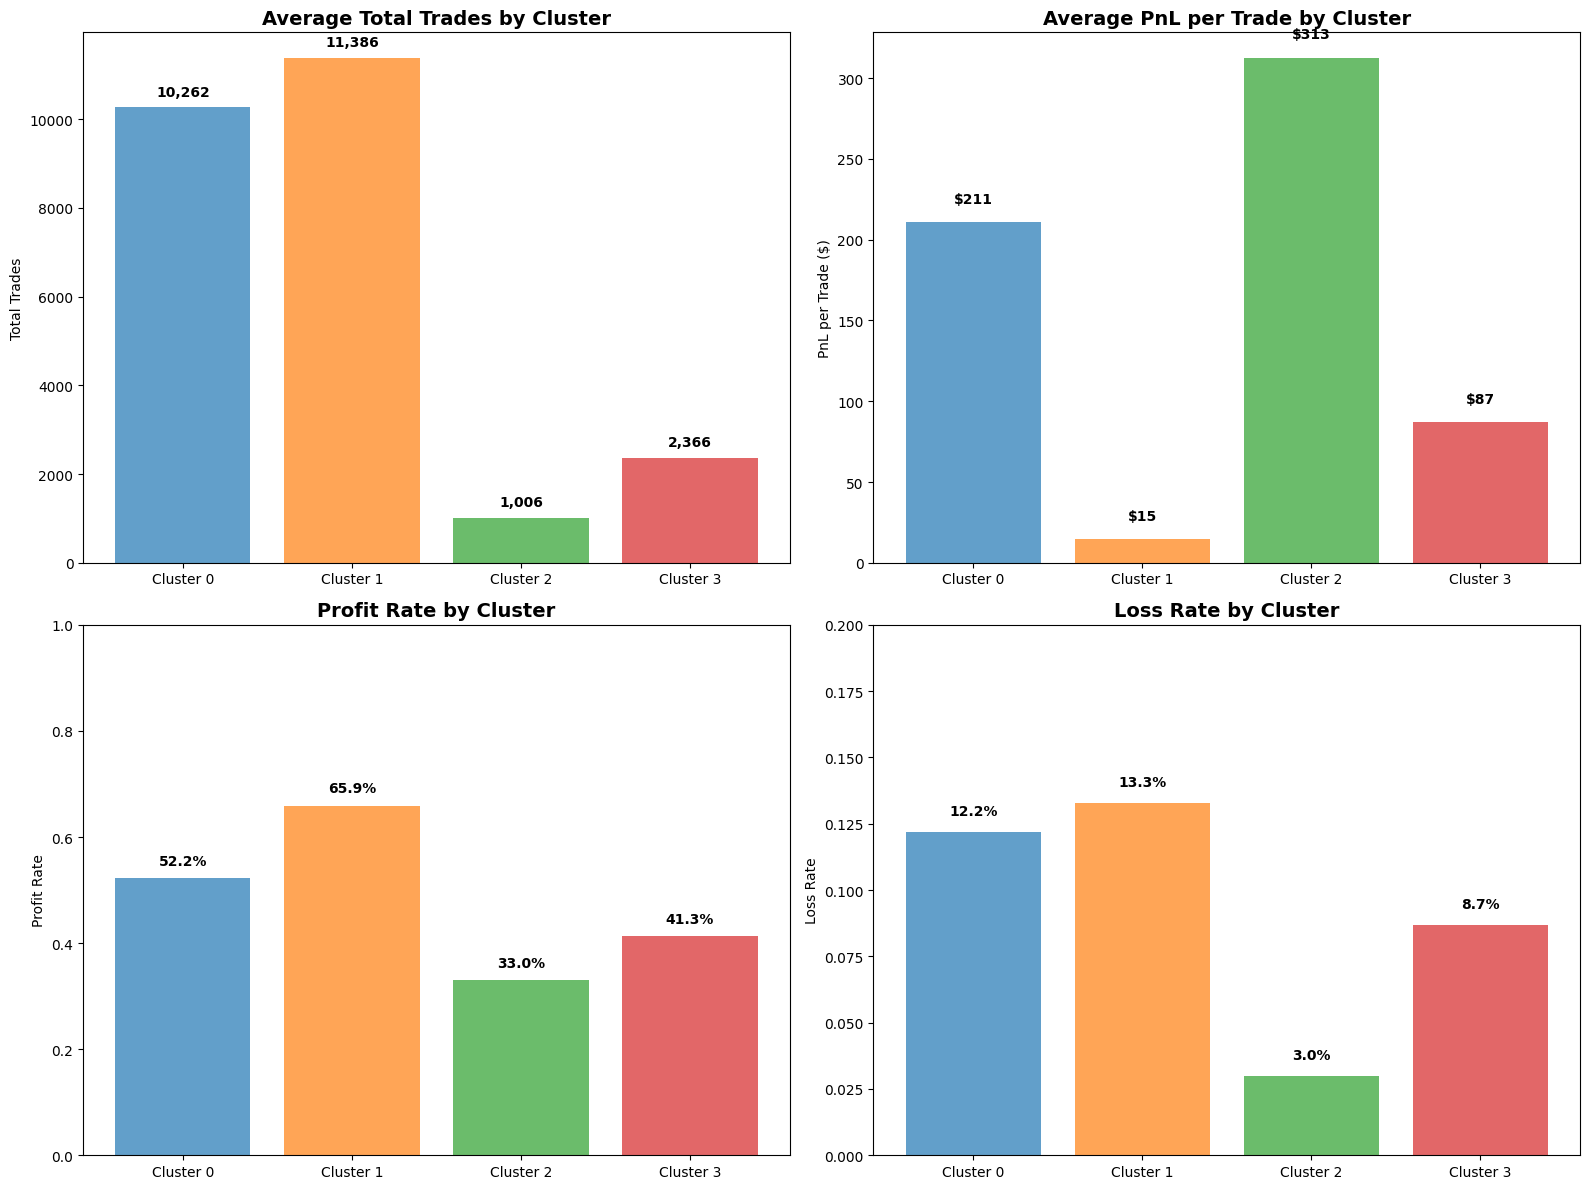

In [125]:
# Extract NEW cluster data from your enhanced clustering results
cluster_data = {
    'Cluster 0': {
        'Total_Trades': 10262.33, 'Total_PnL': 1528012, 'Total_Volume': 179705800, 
        'Avg_PnL_per_Trade': 211.10, 'Count': 3, 'Loss_Rate': 0.122, 'Profit_Rate': 0.522, 'Neutral_Rate': 0.356
    },
    'Cluster 1': {
        'Total_Trades': 11385.85, 'Total_PnL': 210717, 'Total_Volume': 30707940, 
        'Avg_PnL_per_Trade': 14.90, 'Count': 13, 'Loss_Rate': 0.133, 'Profit_Rate': 0.659, 'Neutral_Rate': 0.208
    },
    'Cluster 2': {
        'Total_Trades': 1006.25, 'Total_PnL': 281948, 'Total_Volume': 2183210, 
        'Avg_PnL_per_Trade': 312.75, 'Count': 4, 'Loss_Rate': 0.030, 'Profit_Rate': 0.330, 'Neutral_Rate': 0.640
    },
    'Cluster 3': {
        'Total_Trades': 2366.33, 'Total_PnL': 153818, 'Total_Volume': 20344500, 
        'Avg_PnL_per_Trade': 87.33, 'Count': 12, 'Loss_Rate': 0.087, 'Profit_Rate': 0.413, 'Neutral_Rate': 0.500
    }
}

# Create enhanced visualization with performance rates
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
clusters = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# 1. Total Trades by Cluster
trades_data = [cluster_data[c]['Total_Trades'] for c in clusters]
ax1.bar(clusters, trades_data, color=colors, alpha=0.7)
ax1.set_title('Average Total Trades by Cluster', fontsize=14, fontweight='bold')
ax1.set_ylabel('Total Trades')
for i, v in enumerate(trades_data):
    ax1.text(i, v + 200, f'{v:,.0f}', ha='center', va='bottom', fontweight='bold')

# 2. Average PnL per Trade by Cluster  
avg_pnl_data = [cluster_data[c]['Avg_PnL_per_Trade'] for c in clusters]
ax2.bar(clusters, avg_pnl_data, color=colors, alpha=0.7)
ax2.set_title('Average PnL per Trade by Cluster', fontsize=14, fontweight='bold')
ax2.set_ylabel('PnL per Trade ($)')
for i, v in enumerate(avg_pnl_data):
    ax2.text(i, v + 10, f'${v:.0f}', ha='center', va='bottom', fontweight='bold')

# 3. NEW: Profit Rate by Cluster
profit_rate_data = [cluster_data[c]['Profit_Rate'] for c in clusters]
ax3.bar(clusters, profit_rate_data, color=colors, alpha=0.7)
ax3.set_title('Profit Rate by Cluster', fontsize=14, fontweight='bold')
ax3.set_ylabel('Profit Rate')
ax3.set_ylim(0, 1)
for i, v in enumerate(profit_rate_data):
    ax3.text(i, v + 0.02, f'{v:.1%}', ha='center', va='bottom', fontweight='bold')

# 4. NEW: Loss Rate by Cluster
loss_rate_data = [cluster_data[c]['Loss_Rate'] for c in clusters]
ax4.bar(clusters, loss_rate_data, color=colors, alpha=0.7)
ax4.set_title('Loss Rate by Cluster', fontsize=14, fontweight='bold')
ax4.set_ylabel('Loss Rate')
ax4.set_ylim(0, 0.2)
for i, v in enumerate(loss_rate_data):
    ax4.text(i, v + 0.005, f'{v:.1%}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


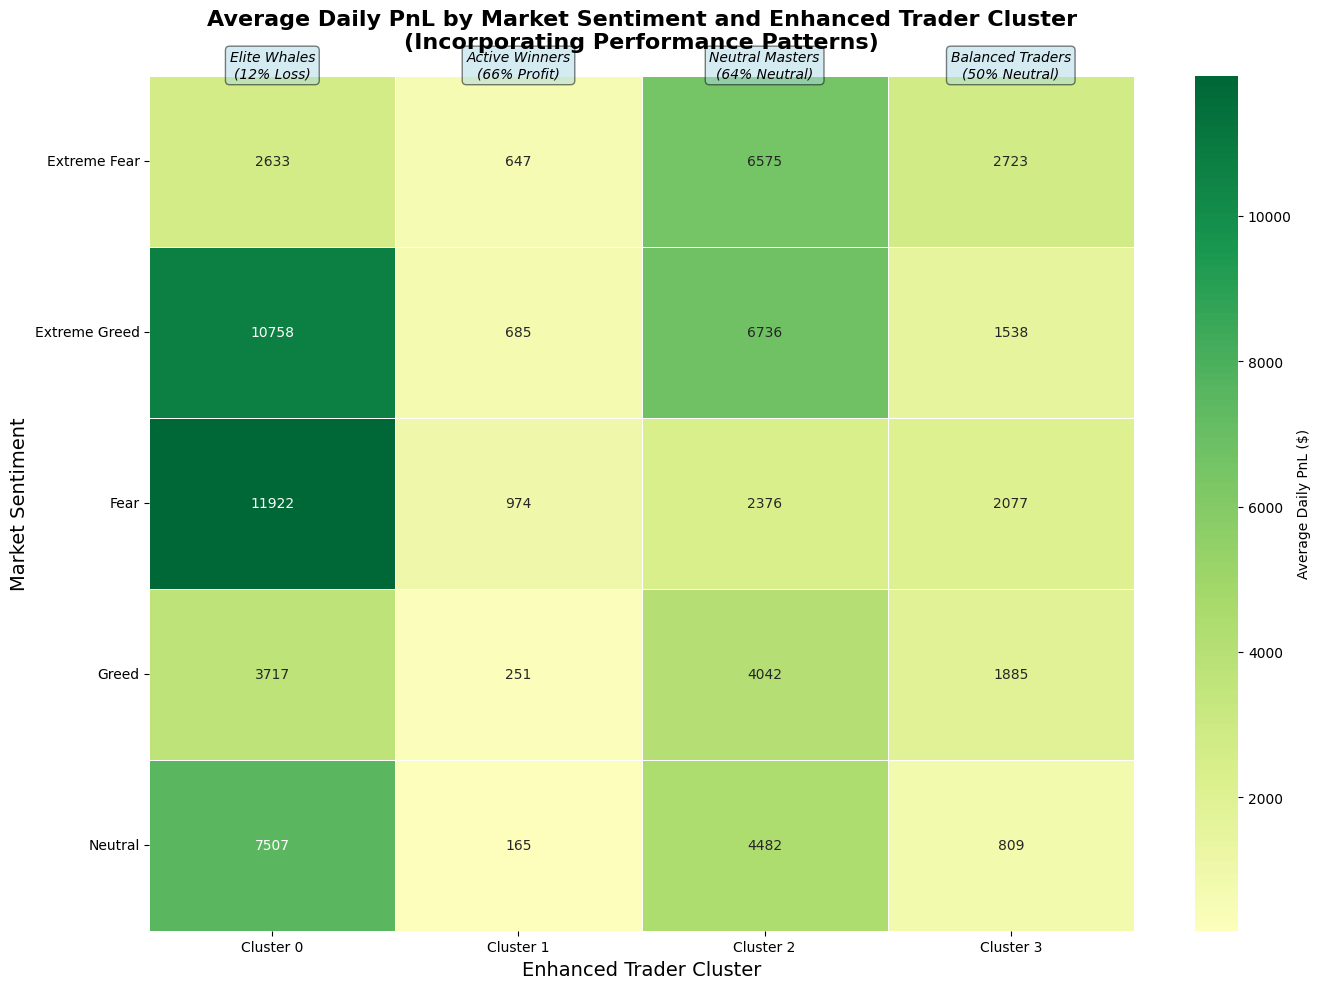

In [126]:
# Create the pivot table from your NEW enhanced clustering results
sentiment_performance_data = {
    'Extreme Fear': [2633.01, 647.12, 6574.97, 2723.00],
    'Extreme Greed': [10757.80, 684.74, 6735.67, 1538.43],
    'Fear': [11922.01, 974.15, 2375.64, 2077.12],
    'Greed': [3716.89, 251.07, 4042.29, 1885.36], 
    'Neutral': [7506.53, 165.48, 4482.29, 809.28]
}

# Create DataFrame
sentiment_df = pd.DataFrame(sentiment_performance_data, 
                        index=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])

# Create enhanced heatmap
plt.figure(figsize=(14, 10))
heatmap = sns.heatmap(sentiment_df.T, 
                    annot=True, 
                    fmt='.0f',
                    cmap='RdYlGn',
                    center=0,
                    cbar_kws={'label': 'Average Daily PnL ($)'},
                    linewidths=0.5,
                    linecolor='white')

plt.title('Average Daily PnL by Market Sentiment and Enhanced Trader Cluster\n(Incorporating Performance Patterns)', 
        fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Enhanced Trader Cluster', fontsize=14)
plt.ylabel('Market Sentiment', fontsize=14)
plt.xticks(rotation=0)
plt.yticks(rotation=0)

# Add cluster annotations
cluster_labels = ['Elite Whales\n(12% Loss)', 'Active Winners\n(66% Profit)', 
                'Neutral Masters\n(64% Neutral)', 'Balanced Traders\n(50% Neutral)']
ax = plt.gca()
for i, label in enumerate(cluster_labels):
    ax.text(i+0.5, -0.15, label, ha='center', va='top', transform=ax.transData, 
            fontsize=10, style='italic', bbox=dict(boxstyle='round,pad=0.3', 
            facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.show()


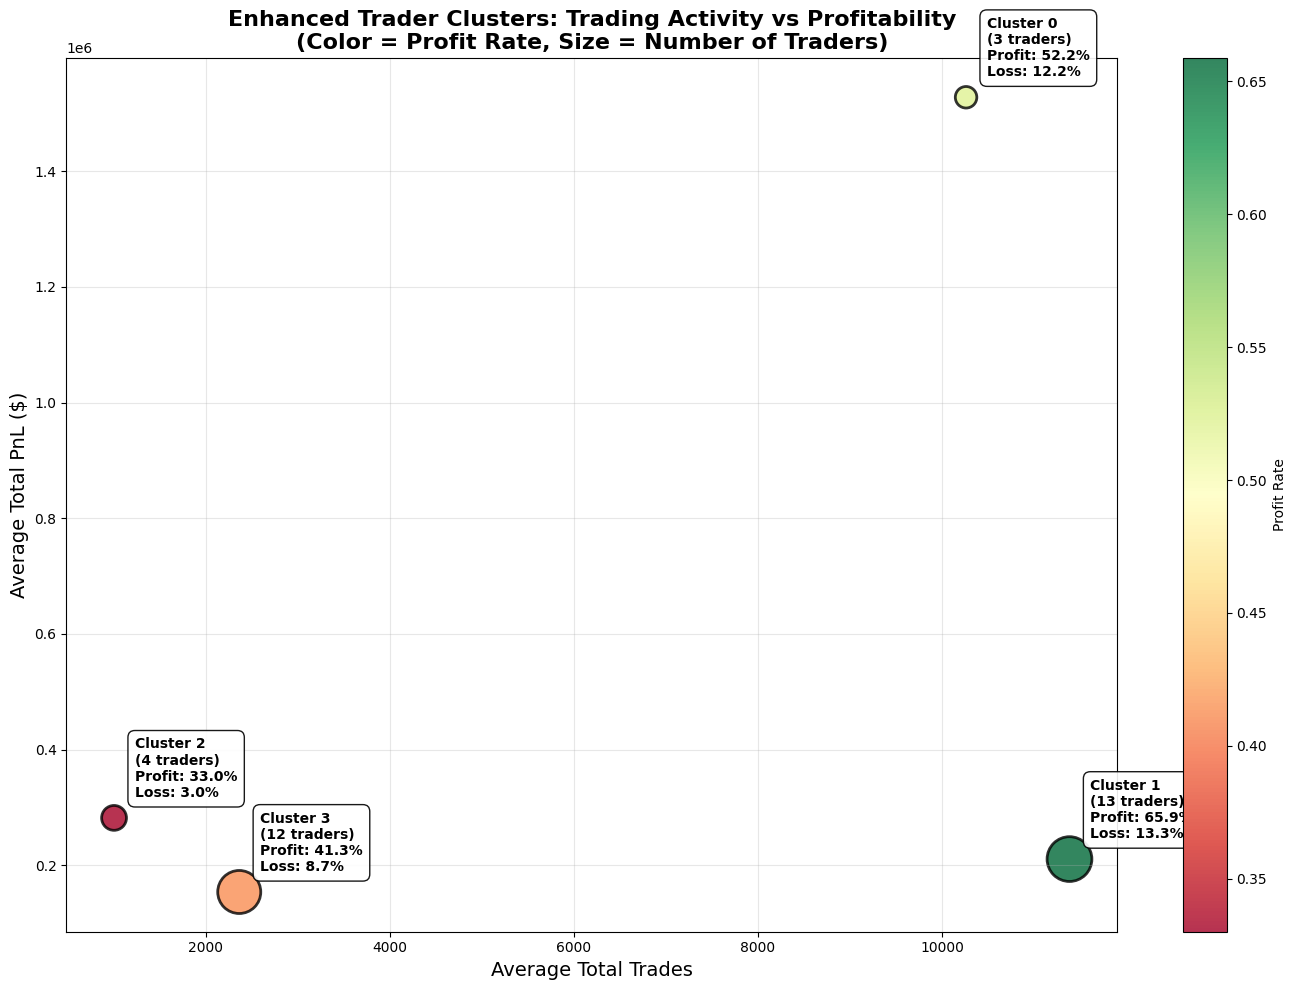

In [127]:
# Extract data for enhanced scatter plot
scatter_data = []
for cluster, data in cluster_data.items():
    cluster_num = int(cluster.split()[1])
    scatter_data.append([data['Total_Trades'], data['Total_PnL'], cluster_num, 
                        data['Count'], data['Profit_Rate'], data['Loss_Rate']])

scatter_df = pd.DataFrame(scatter_data, columns=['Total_Trades', 'Total_PnL', 'Cluster', 
                                               'Trader_Count', 'Profit_Rate', 'Loss_Rate'])

plt.figure(figsize=(14, 10))
scatter = plt.scatter(scatter_df['Total_Trades'], 
                    scatter_df['Total_PnL'],
                    c=scatter_df['Profit_Rate'],
                    s=scatter_df['Trader_Count'] * 80,  # Size based on number of traders
                    cmap='RdYlGn',
                    alpha=0.8,
                    edgecolors='black',
                    linewidth=2)

plt.xlabel('Average Total Trades', fontsize=14)
plt.ylabel('Average Total PnL ($)', fontsize=14)
plt.title('Enhanced Trader Clusters: Trading Activity vs Profitability\n(Color = Profit Rate, Size = Number of Traders)', 
          fontsize=16, fontweight='bold')

# Add enhanced cluster labels with performance info
for i, row in scatter_df.iterrows():
    label = f'Cluster {int(row["Cluster"])}\n({int(row["Trader_Count"])} traders)\nProfit: {row["Profit_Rate"]:.1%}\nLoss: {row["Loss_Rate"]:.1%}'
    plt.annotate(label, 
                (row['Total_Trades'], row['Total_PnL']),
                xytext=(15, 15), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9),
                fontsize=10, fontweight='bold')

plt.colorbar(scatter, label='Profit Rate')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [128]:
# Creating Enhanced Cluster Archetype Summary with Performance Patterns
cluster_archetypes = {
    'Cluster 0': {
        'Name': 'Elite Whale Traders', 
        'Description': 'Ultra-high volume traders with massive capital, balanced win-loss ratio, highest efficiency'
    },
    'Cluster 1': {
        'Name': 'Active Winners', 
        'Description': 'High-activity traders with exceptional profit rates (66%), largest group, consistent performers'
    },  
    'Cluster 2': {
        'Name': 'Neutral Strategy Masters', 
        'Description': 'Conservative traders specializing in neutral outcomes (64%), lowest loss rate, ultra-efficient'
    },
    'Cluster 3': {
        'Name': 'Balanced Moderates', 
        'Description': 'Medium activity balanced traders, even split between neutral/profit outcomes'
    }
}

# Enhanced archetype summary with performance metrics
print("=== ENHANCED TRADER ARCHETYPE SUMMARY (WITH PERFORMANCE PATTERNS) ===")
for cluster, info in cluster_archetypes.items():
    data = cluster_data[cluster]
    print(f"\n{cluster}: {info['Name']}")
    print(f"Description: {info['Description']}")
    print(f"Traders: {data['Count']}")
    print(f"Avg Trades: {data['Total_Trades']:,.0f}")
    print(f"Avg PnL: ${data['Total_PnL']:,.0f}")
    print(f"Efficiency: ${data['Avg_PnL_per_Trade']:.0f} per trade")
    print(f"PERFORMANCE PATTERN:")
    print(f"  • Profit Rate: {data['Profit_Rate']:.1%}")
    print(f"  • Loss Rate: {data['Loss_Rate']:.1%}")  
    print(f"  • Neutral Rate: {data['Neutral_Rate']:.1%}")
    print(f"Risk Profile: {'Ultra-Safe' if data['Loss_Rate'] < 0.05 else 'Safe' if data['Loss_Rate'] < 0.10 else 'Moderate' if data['Loss_Rate'] < 0.15 else 'Aggressive'}")
    print("=" * 70)


=== ENHANCED TRADER ARCHETYPE SUMMARY (WITH PERFORMANCE PATTERNS) ===

Cluster 0: Elite Whale Traders
Description: Ultra-high volume traders with massive capital, balanced win-loss ratio, highest efficiency
Traders: 3
Avg Trades: 10,262
Avg PnL: $1,528,012
Efficiency: $211 per trade
PERFORMANCE PATTERN:
  • Profit Rate: 52.2%
  • Loss Rate: 12.2%
  • Neutral Rate: 35.6%
Risk Profile: Moderate

Cluster 1: Active Winners
Description: High-activity traders with exceptional profit rates (66%), largest group, consistent performers
Traders: 13
Avg Trades: 11,386
Avg PnL: $210,717
Efficiency: $15 per trade
PERFORMANCE PATTERN:
  • Profit Rate: 65.9%
  • Loss Rate: 13.3%
  • Neutral Rate: 20.8%
Risk Profile: Moderate

Cluster 2: Neutral Strategy Masters
Description: Conservative traders specializing in neutral outcomes (64%), lowest loss rate, ultra-efficient
Traders: 4
Avg Trades: 1,006
Avg PnL: $281,948
Efficiency: $313 per trade
PERFORMANCE PATTERN:
  • Profit Rate: 33.0%
  • Loss Rate: 3.0

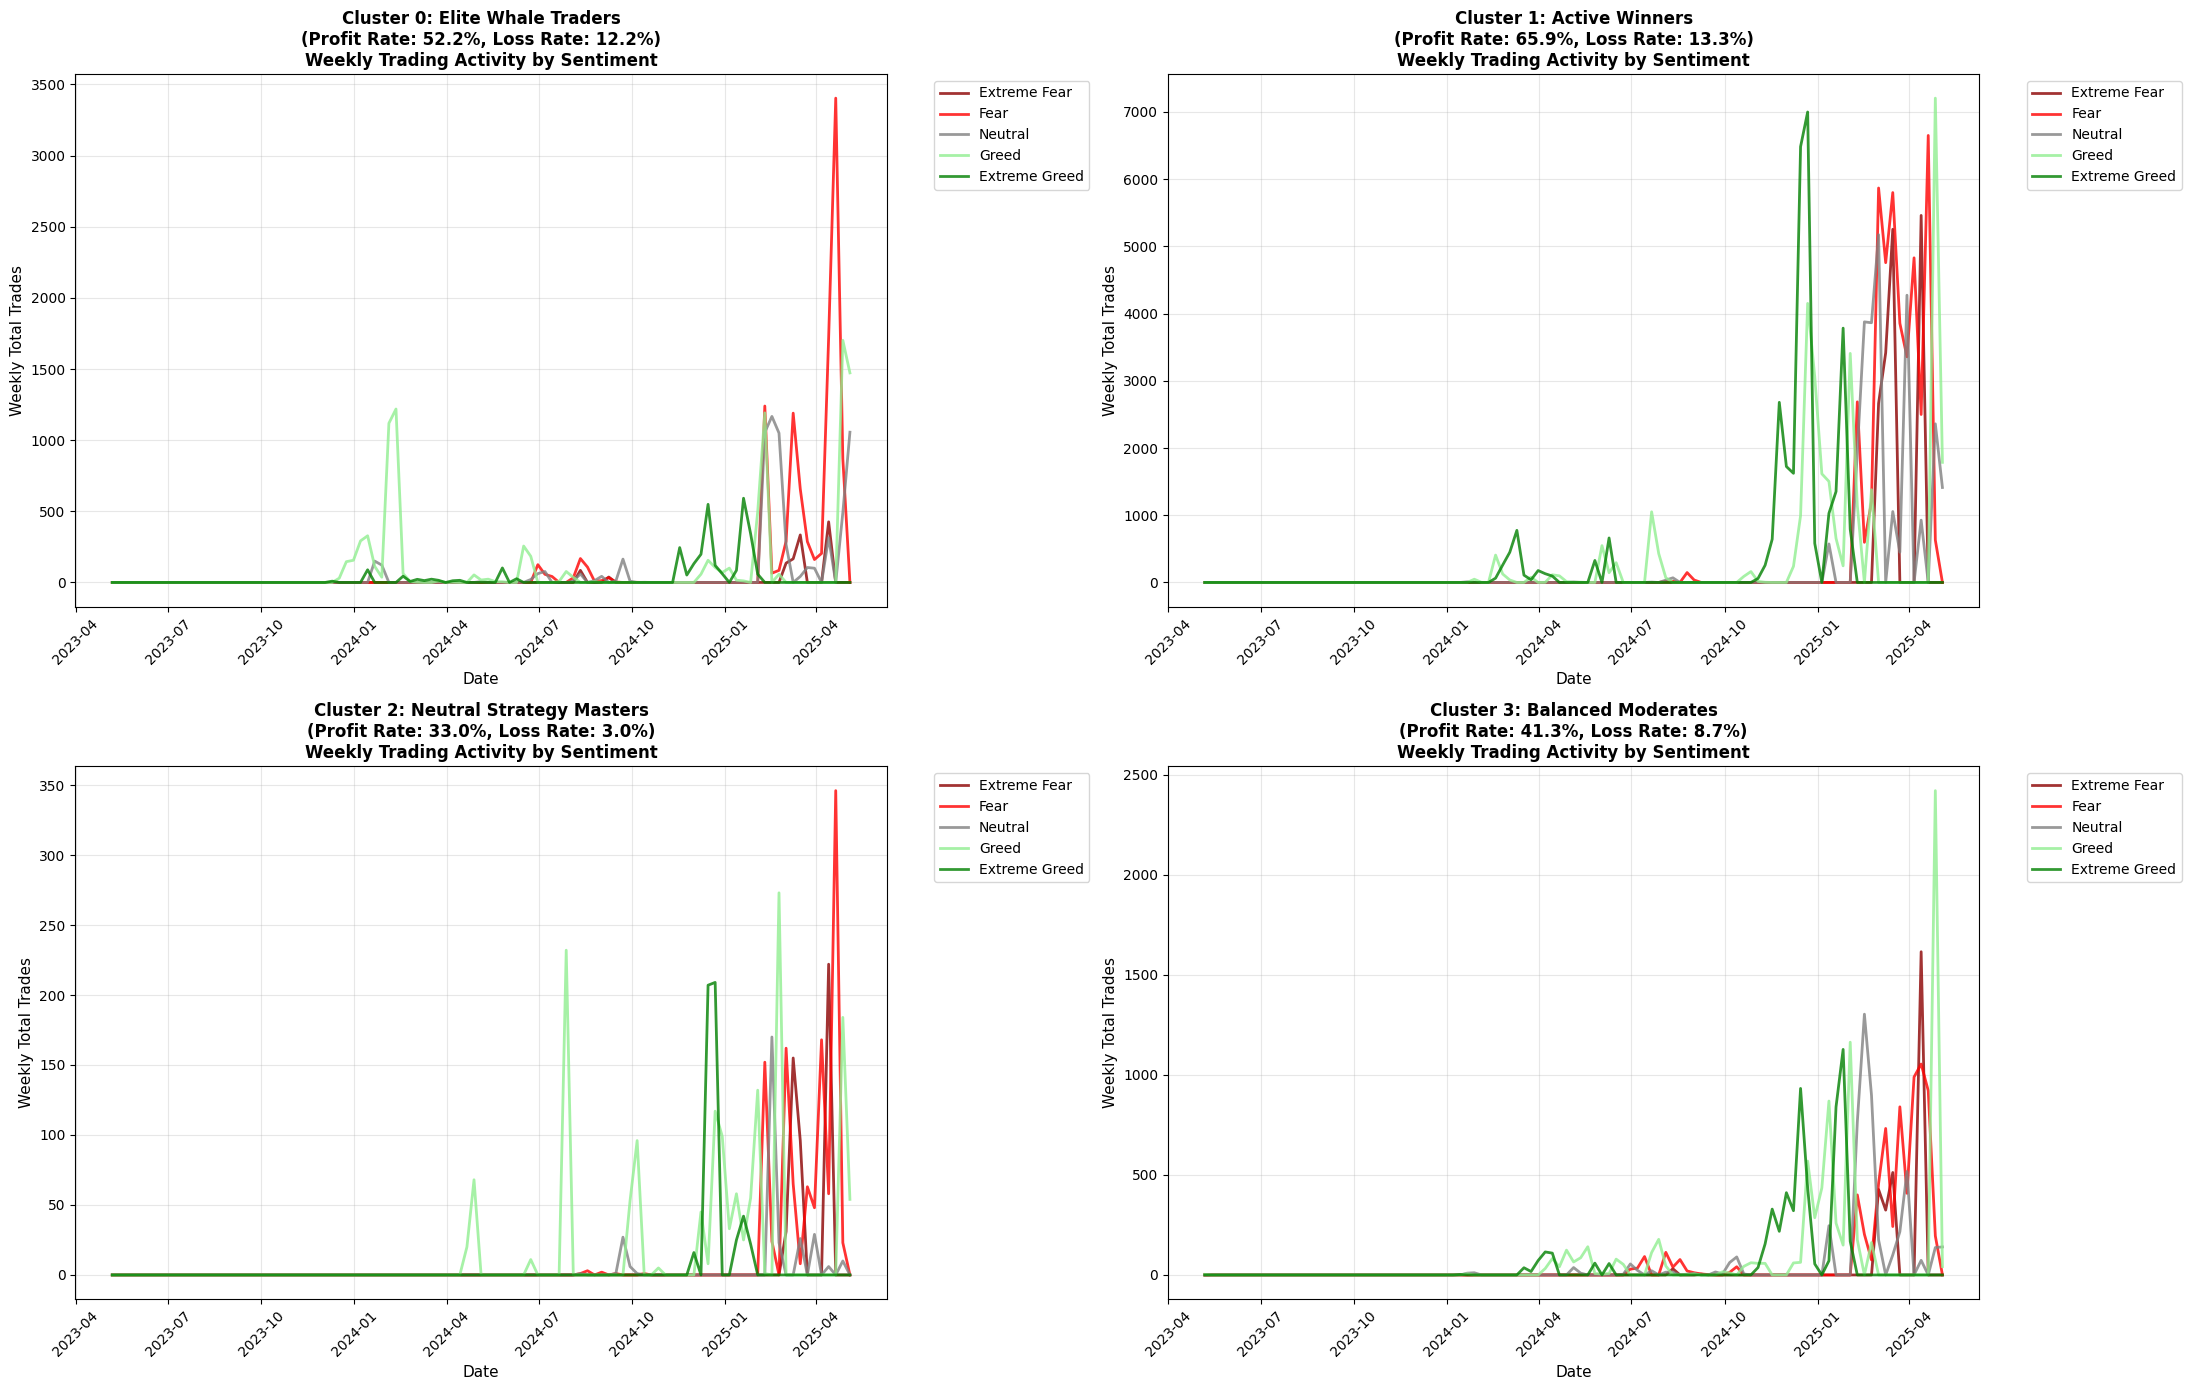

In [129]:
# Temporal Analysis - Trading Activity by Enhanced Cluster and Sentiment Over Time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Aggregate total trades over time by NEW cluster and sentiment
trades_over_time = combined_final_df.groupby(['date', 'Cluster', 'classification'])['Daily_Trades'].sum().reset_index()

# 2. Create weekly aggregation for smoother visualization
trades_over_time['date'] = pd.to_datetime(trades_over_time['date'])
trades_over_time.set_index('date', inplace=True)

# Pivot table for easier plotting
pivot_trades = trades_over_time.pivot_table(
    index='date', 
    columns=['Cluster', 'classification'], 
    values='Daily_Trades', 
    fill_value=0
)

# Resample to weekly data to reduce noise
weekly_trades = pivot_trades.resample('W').sum()

# 3. Create the multi-panel plot with ENHANCED cluster names
fig, axes = plt.subplots(2, 2, figsize=(22, 14))
clusters = [0, 1, 2, 3]
cluster_names = ['Elite Whale Traders', 'Active Winners', 'Neutral Strategy Masters', 'Balanced Moderates']
sentiments = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
colors = ['darkred', 'red', 'gray', 'lightgreen', 'green']

for i, cluster in enumerate(clusters):
    ax = axes[i//2, i%2]
    
    for sentiment, color in zip(sentiments, colors):
        if (cluster, sentiment) in weekly_trades.columns:
            data = weekly_trades[(cluster, sentiment)]
            ax.plot(data.index, data.values, label=sentiment, color=color, linewidth=2, alpha=0.8)
    
    # Enhanced title with cluster characteristics
    cluster_info = cluster_data[f'Cluster {cluster}']
    title = f'Cluster {cluster}: {cluster_names[i]}\n(Profit Rate: {cluster_info["Profit_Rate"]:.1%}, Loss Rate: {cluster_info["Loss_Rate"]:.1%})\nWeekly Trading Activity by Sentiment'
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Date', fontsize=11)
    ax.set_ylabel('Weekly Total Trades', fontsize=11)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


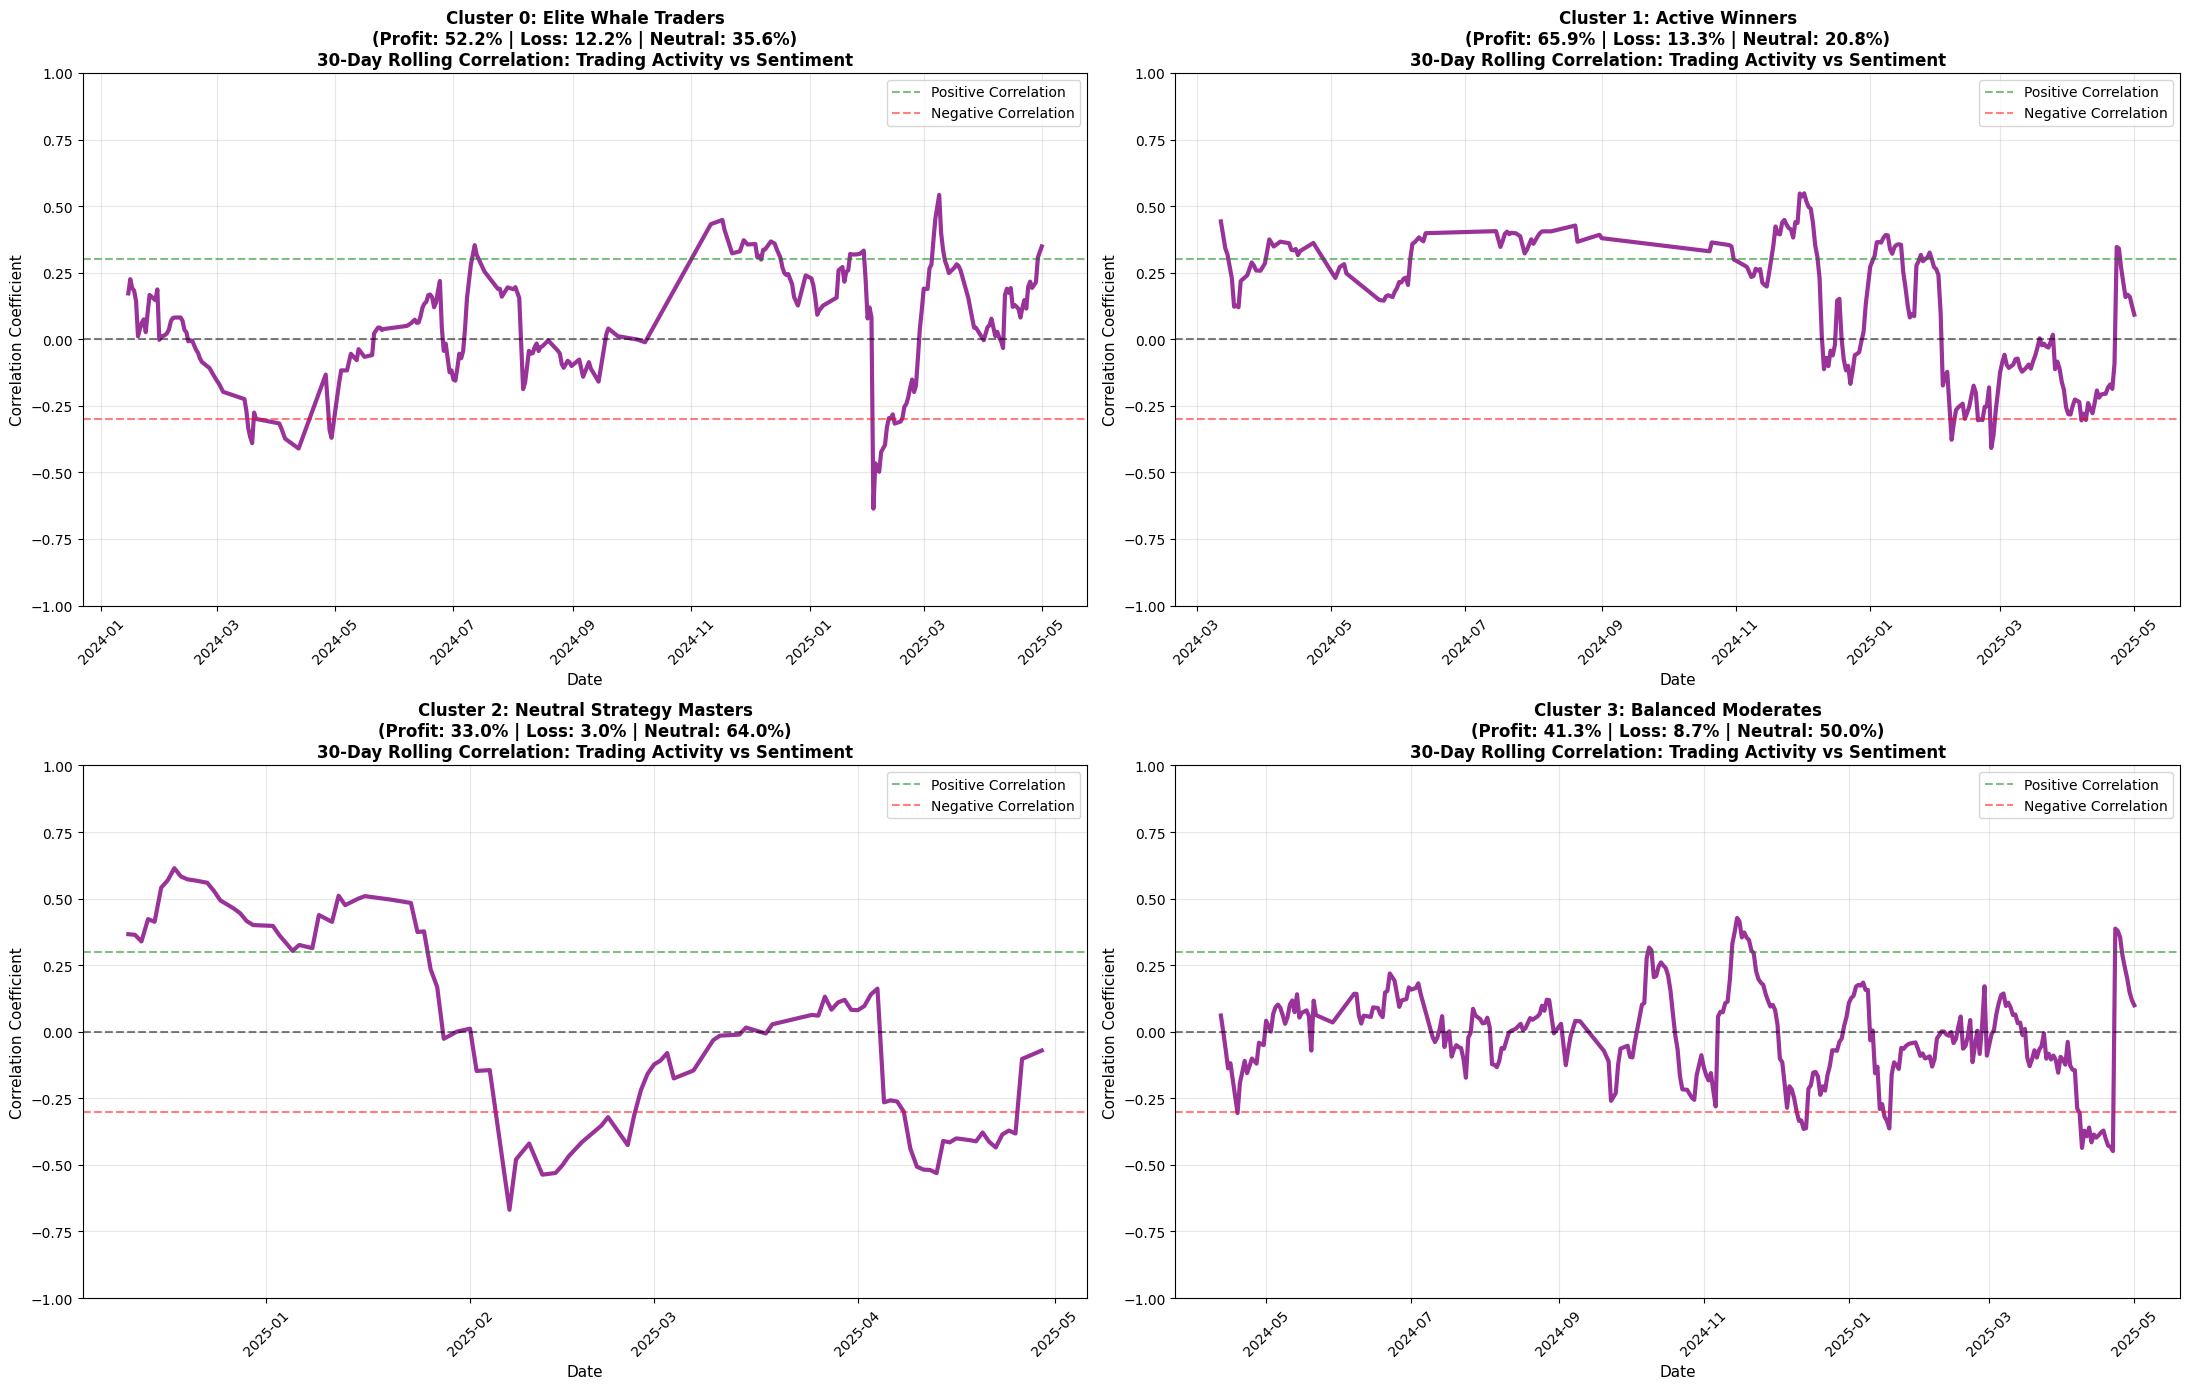

In [130]:
# Create rolling 30-day correlation with ENHANCED clusters
rolling_window = 30
fig, axes = plt.subplots(2, 2, figsize=(22, 14))

for i, cluster in enumerate(clusters):
    ax = axes[i//2, i%2]
    
    # Get daily sentiment values and total daily trades for this cluster
    cluster_daily = combined_final_df[combined_final_df['Cluster'] == cluster].groupby('date').agg({
        'Daily_Trades': 'sum',
        'value': 'first'  # Sentiment value is same for all traders on same date
    })
    
    # Calculate rolling correlation
    rolling_corr = cluster_daily['Daily_Trades'].rolling(window=rolling_window).corr(cluster_daily['value'])
    
    ax.plot(rolling_corr.index, rolling_corr.values, linewidth=3, color='purple', alpha=0.8)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax.axhline(y=0.3, color='green', linestyle='--', alpha=0.5, label='Positive Correlation')
    ax.axhline(y=-0.3, color='red', linestyle='--', alpha=0.5, label='Negative Correlation')
    
    # Enhanced title with performance characteristics
    cluster_info = cluster_data[f'Cluster {cluster}']
    title = f'Cluster {cluster}: {cluster_names[i]}\n(Profit: {cluster_info["Profit_Rate"]:.1%} | Loss: {cluster_info["Loss_Rate"]:.1%} | Neutral: {cluster_info["Neutral_Rate"]:.1%})\n30-Day Rolling Correlation: Trading Activity vs Sentiment'
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Date', fontsize=11)
    ax.set_ylabel('Correlation Coefficient', fontsize=11)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(-1, 1)

plt.tight_layout()
plt.show()


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4780\2898741644.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_final_df, x='classification', y='Daily_PnL',
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4780\2898741644.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  profit_by_sentiment_cluster = combined_final_df.groupby(['classification', 'Cluster']).apply(


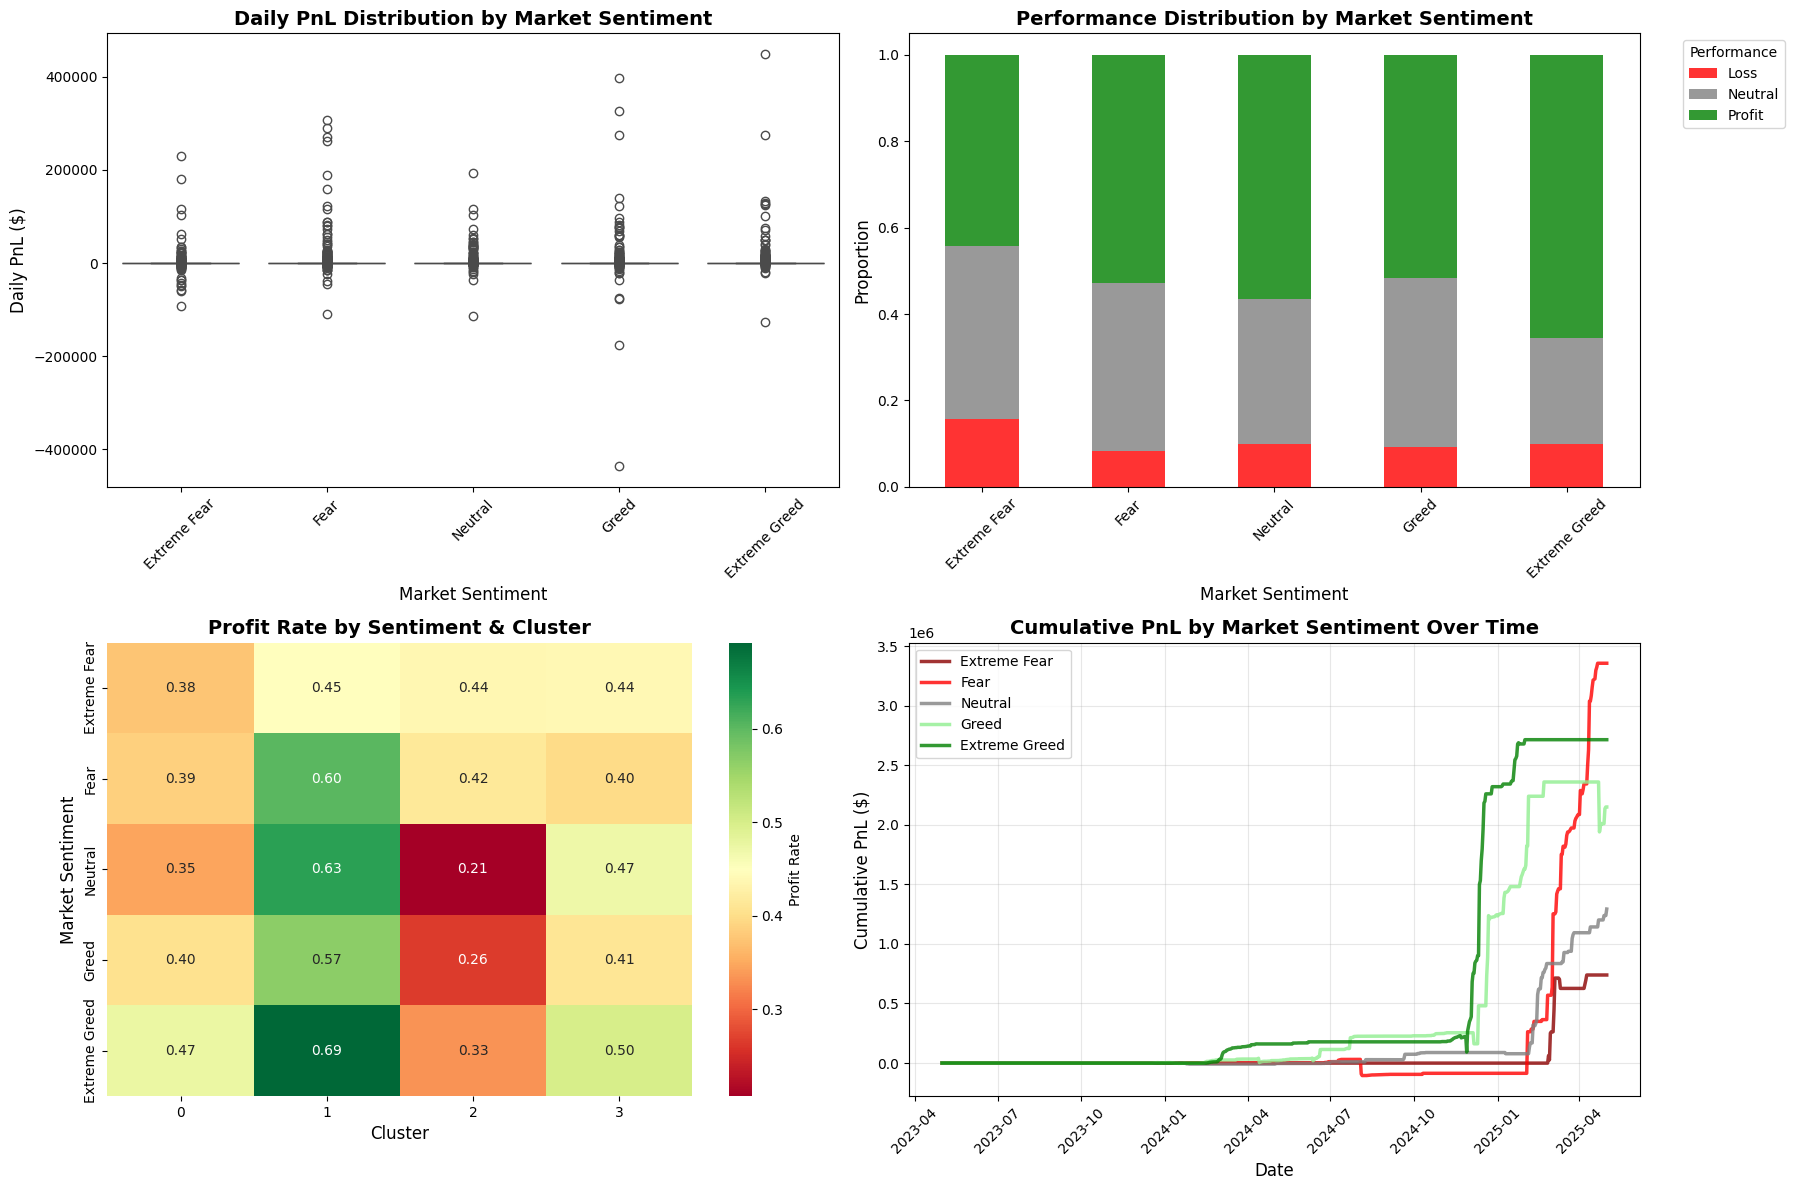

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. Overall Profit Distribution by Market Sentiment
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# Subplot 1: Average Daily PnL by Sentiment (Box Plot)
sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
sns.boxplot(data=combined_final_df, x='classification', y='Daily_PnL', 
        order=sentiment_order, ax=ax1, palette='RdYlGn')
ax1.set_title('Daily PnL Distribution by Market Sentiment', fontsize=14, fontweight='bold')
ax1.set_xlabel('Market Sentiment', fontsize=12)
ax1.set_ylabel('Daily PnL ($)', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

# Subplot 2: Performance Category Distribution by Sentiment
performance_sentiment = pd.crosstab(combined_final_df['classification'], 
                                combined_final_df['Performance'], normalize='index')
performance_sentiment = performance_sentiment.reindex(sentiment_order)
performance_sentiment.plot(kind='bar', stacked=True, ax=ax2, 
                        color=['red', 'gray', 'green'], alpha=0.8)
ax2.set_title('Performance Distribution by Market Sentiment', fontsize=14, fontweight='bold')
ax2.set_xlabel('Market Sentiment', fontsize=12)
ax2.set_ylabel('Proportion', fontsize=12)
ax2.legend(title='Performance', bbox_to_anchor=(1.05, 1))
ax2.tick_params(axis='x', rotation=45)

# Subplot 3: Average Profit Rate by Sentiment and Cluster
profit_by_sentiment_cluster = combined_final_df.groupby(['classification', 'Cluster']).apply(
    lambda x: (x['Performance'] == 'Profit').mean()
).unstack().reindex(sentiment_order)

sns.heatmap(profit_by_sentiment_cluster, annot=True, fmt='.2f', cmap='RdYlGn', 
        ax=ax3, cbar_kws={'label': 'Profit Rate'})
ax3.set_title('Profit Rate by Sentiment & Cluster', fontsize=14, fontweight='bold')
ax3.set_xlabel('Cluster', fontsize=12)
ax3.set_ylabel('Market Sentiment', fontsize=12)

# Subplot 4: Cumulative PnL by Sentiment Over Time
daily_sentiment_pnl = combined_final_df.groupby(['date', 'classification'])['Daily_PnL'].sum().unstack(fill_value=0)
cumulative_pnl = daily_sentiment_pnl.cumsum()

colors_sentiment = ['darkred', 'red', 'gray', 'lightgreen', 'green']
for i, sentiment in enumerate(sentiment_order):
    if sentiment in cumulative_pnl.columns:
        ax4.plot(cumulative_pnl.index, cumulative_pnl[sentiment], 
                label=sentiment, color=colors_sentiment[i], linewidth=2.5, alpha=0.8)

ax4.set_title('Cumulative PnL by Market Sentiment Over Time', fontsize=14, fontweight='bold')
ax4.set_xlabel('Date', fontsize=12)
ax4.set_ylabel('Cumulative PnL ($)', fontsize=12)
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [132]:
# 3. SUMMARY STATISTICS TABLE
print("=== PROFIT vs MARKET SENTIMENT SUMMARY STATISTICS ===")
summary_stats = combined_final_df.groupby(['classification', 'Performance']).agg({
    'Daily_PnL': ['count', 'mean', 'median', 'std'],
    'Daily_Volume': 'mean',
    'Daily_Trades': 'mean'
}).round(2)

print("\nDetailed breakdown:")
for sentiment in sentiment_order:
    if sentiment in combined_final_df['classification'].values:
        sentiment_data = combined_final_df[combined_final_df['classification'] == sentiment]
        profit_rate = (sentiment_data['Performance'] == 'Profit').mean()
        loss_rate = (sentiment_data['Performance'] == 'Loss').mean()
        neutral_rate = (sentiment_data['Performance'] == 'Neutral').mean()
        avg_profit = sentiment_data[sentiment_data['Performance'] == 'Profit']['Daily_PnL'].mean()
        avg_loss = sentiment_data[sentiment_data['Performance'] == 'Loss']['Daily_PnL'].mean()
        
        print(f"\n{sentiment}:")
        print(f"  Profit Rate: {profit_rate:.1%}")
        print(f"  Loss Rate: {loss_rate:.1%}")
        print(f"  Neutral Rate: {neutral_rate:.1%}")
        print(f"  Avg Profit when Profitable: ${avg_profit:.2f}")
        print(f"  Avg Loss when Losing: ${avg_loss:.2f}")
        print(f"  Total Records: {len(sentiment_data):,}")

=== PROFIT vs MARKET SENTIMENT SUMMARY STATISTICS ===

Detailed breakdown:

Extreme Fear:
  Profit Rate: 44.3%
  Loss Rate: 15.6%
  Neutral Rate: 40.1%
  Avg Profit when Profitable: $6579.45
  Avg Loss when Losing: $-8376.35
  Total Records: 461

Fear:
  Profit Rate: 52.8%
  Loss Rate: 8.3%
  Neutral Rate: 38.9%
  Avg Profit when Profitable: $4860.95
  Avg Loss when Losing: $-3480.83
  Total Records: 1,474

Neutral:
  Profit Rate: 56.6%
  Loss Rate: 9.9%
  Neutral Rate: 33.5%
  Avg Profit when Profitable: $2615.69
  Avg Loss when Losing: $-2828.51
  Total Records: 1,078

Greed:
  Profit Rate: 51.7%
  Loss Rate: 9.3%
  Neutral Rate: 39.1%
  Avg Profit when Profitable: $2856.66
  Avg Loss when Losing: $-5054.38
  Total Records: 2,135

Extreme Greed:
  Profit Rate: 65.5%
  Loss Rate: 9.9%
  Neutral Rate: 24.6%
  Avg Profit when Profitable: $2289.23
  Avg Loss when Losing: $-1231.90
  Total Records: 1,972
